# **Identificando Trânsito Planetário usando o Método Box Least Square**
* PET - Física
* Petianos: Emanuel e Ylana
* Data: 24 de Outubro de 2024

$\quad$O objetivo deste `Notebook`é calcular o período de trânsito do exoplaneta TOI-1408b [1]. Utilizaremos a fotometria do TESS e o método Box Least Squares (BLS) embutido na biblioteca lightkurve. Ao longo deste `Notebook`, iremos introduzir o método de detecção de exoplanetas por trânsito planetário, assim como noções básicas de dados em astronomia, de forma que não é necessário conhecimento prévio no assunto. Seguiremos os seguintes pontos:

1. *Introdução*;
2. *Trânsito Planetário*
3. *O algoritmo BLS*
4. *Aplicação e modelagem*
5. *Conclusão*


$\quad$ Para que o leitor possa seguir com os códigos deste `Notebook`, é necessário instalar a biblioteca `lightkurve`, que é a ferramenta principal para esse trabalho. Este pacote pode ser instalado executando o comando `python -m pip install lightkurve` em uma janela de terminal.

### **Importando as bibliotecas**

In [14]:
import lightkurve as  lk
import matplotlib.pyplot as plt 

%matplotlib inline

### **Informações sobre as bibliotecas**

In [15]:
%load_ext version_information
%version_information matplotlib, lightkurve

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.11.5 64bit [MSC v.1916 64 bit (AMD64)]
IPython 8.15.0
OS Windows 10 10.0.19045 SP0
matplotlib 3.7.2
lightkurve 2.4.2
Thu Oct 24 21:22:36 2024 Hora oficial do Brasil

## **1. Introdução**

$\quad$Ao longo desta primeira seção, iremos abordar um pouco da técnica de fotometria, como é possível detectar exoplanetas por trânsito planetário e introduzir o TESS, instrumento de onde estaremos utilizando os dados.

### **1.1 Fotometria**

$\quad$O termo fotometria surgiu com os oculistas, referindo-se à medida da quantidade de energia associada às sensações visuais. A fotometria é basicamente o estudo da quantidade de luz que chega até o observador. Hoje, usamos instrumentos muito mais sensíveis do que o olho humano para coletar esses dados, como câmeras digitais com CCDs (charge-coupled devices), que captam a luz de um objeto e a transformam em um sinal eletrônico que pode ser quantificado. Isso tudo, claro, em conjunto com um telescópio que foca e coleta a luz de um objeto distante **[3]**.

$\quad$Com isso, o que importa mais para nós neste momento é a curva de luz, que consiste no gráfico da variação do brilho do objeto — fluxo, medido em elétrons por segundo  $e^-s^{-1} $  — ao longo do tempo, que estará no sistema BTJD (Barycentric Julian Date).

### **1.2 TESS: Transiting Exoplanet Survey Satellite**


$\quad$A missão TESS foi projetada para detectar planetas por trânsito, com a intenção de dar continuidade à onda de descobertas de exoplanetas do Kepler/K2. Desta vez, as estrelas mais próximas e mais brilhantes foram escolhidas como alvos, para que observações posteriores com telescópios terrestres e/ou outras missões espaciais possam estudar esses alvos mais a fundo.

$\quad$As observações do TESS foram inicialmente divididas em setores (Figura 1) e, ao final de cada observação, o objeto se vira na direção leste, cerca de ~$27°$, para que a observação do próximo setor possa começar. Cada um desses processos leva cerca de 27 dias, sendo sincronizado com a órbita da Lua, o que nos permite observar 13 setores por ano. Com isso, a missão foi planejada para observar o hemisfério sul no primeiro ano e o hemisfério norte no segundo, resultando em 26 setores.


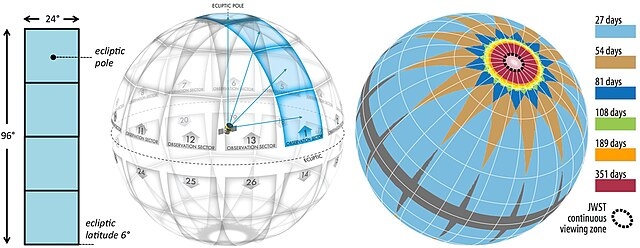

Figura 1 [5]: Repartição dos setores de observação da missão TESS. 

$\quad$A partir das observações conduzidas pelo instrumento, recebemos dois tipos de dados como produto: com 2 minutos e com 30 minutos de exposição. O objeto que trataremos possui ambos os tipos, então usaremos os dois. Caso o leitor tenha interesse, mais detalhes técnicos sobre a missão podem ser encontrados no *TESS Instrument Handbook* **[5]**.

$\quad$Obs.: Algumas siglas importantes:
- *TOI*: TESS Objetc of Interest;
- *TIC*: TESS Input Catalog;
- *TICID*: Número de identificação de um objeto no catálogo.


## 2. Trânsito Planetário

$\quad$Desde a descoberta do primeiro planeta fora do Sistema Solar em 1995, surgiram os mais diversos métodos de busca e detecção de exoplanetas, contribuindo para os mais de 5.000 exoplanetas confirmados até hoje. O trânsito planetário é um desses métodos, sendo responsável por grande parte das detecções **[8]**. Caso um sistema planetário esteja orientado com seu plano orbital alinhado — ou quase — com um observador, são detectadas quedas periódicas na luminosidade da estrela, causadas pelo trânsito dos planetas. Por isso, recebe esse nome, sendo uma ideia simples que é capaz de enxergar longe.

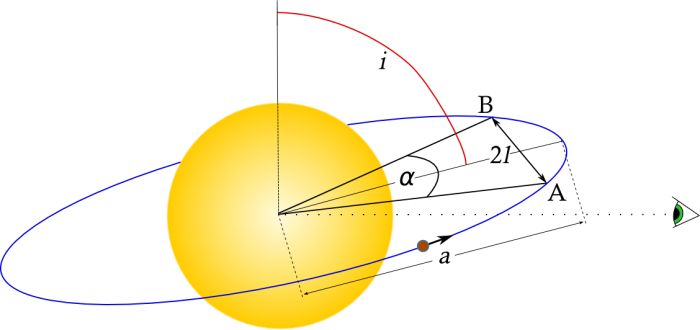

Figura 2: Geometria do trânsito planetário. *Figura adaptada de “Transiting Exoplanets”, de Carole A. Haswell.*

### 2.1 Probabilidade de observar um trânsito

$\quad$Com isso, uma pergunta que pode surgir é: quais são as chances de haver um sistema com essa orientação em relação a nós, os observadores?
Analisando a geometria do problema, podemos chegar a conclusão que um eclipse só seria detectado se:
\begin{equation}
  a cos i \leq R_{*} + R_{p}. \tag{1}
\end{equation}

$\quad$Em que $a$ é distância orbital, $i$ a inclinação do plano orbital e $R_{*}$ e $R_{p}$ os raios da estrela e do planeta. Essa relação basicamente diz que precisamos que o planeta passe entre o observador e a estrela, ocultando uma parte do seu brilho, para podermos detectá-lo. A partir disso, considerando $cosi$ variando de 0 a 1, podemos sair da equação (1) direto para: 
\begin{equation}
  p_{trans} = \frac{R_{*} + R_{p}}{a} \approx \frac{R_{*}}{a}. \tag{2}
\end{equation}

$\quad$Igualamos $p_{trans} = cosi$ para conseguirmos a probabilidade de haver um evento de trânsito ocorrendo na linha de visão do observador em uma amostra de sistemas planetários com inclinações aleatórias. E, como o raio do planeta geralmente é desprezível perto do raio da estrela, podemos aproximar $p_{trans} \approx \frac{R_{*}}{a}$. Mantendo isso em mente, é perceptível como essas características favorecem a detecção de planetas com período orbital curto.

### 2.2 Tempo do trânsito

$\quad$Outro ponto importante desse evento é o tempo que leva para o trânsito acontecer por completo, definido como o tempo de trânsito, $T$. Para encontrar essa relação, vamos analisar a geometria do problema mais uma vez. No nosso caso, estaremos considerando o deslocamento angular do planeta, $\alpha$ (não confundir com $a$ - período orbital), pequeno o suficiente, de forma que podemos aproximar a projeção do segmento da órbita a uma linha reta usando o Teorema de Pitágoras. Representado na figura 2 como $l$:

\begin{equation}
l = \sqrt{(R_{*} + R_{p})² - a² cos²i}. \tag{3}
\end{equation}  

$\quad$Assim, usando da proporcionalidade entre o período orbital e a própria órbita, junto com o valor de $sin(\frac{\alpha}{2})$, chegamos à relação da duração do trânsito:

\begin{equation}
  T_{trans} = \frac{P}{\pi}sin^{-1}(\frac{\sqrt{(R_{*} + R_{p})² - a² cos²i}}{a}). \tag{4}
\end{equation}

$\quad$Em que $P$ é o período orbital do planeta. 

$\quad$Para $a \gg R_{*} \gg R_{p}$, a equação 3 pode ser simplificada usando aproximação para ângulos pequenos e jogando o $a$ para dentro da raiz:

\begin{equation}
        T_{trans} = \frac{P}{\pi}\sqrt{(\frac{R_{*}}{a})² - cos²i}. \tag{5}
\end{equation}

### 2.3 Profundidade do trânsito

$\quad$Para finalizar essa seção, vamos falar sobre a profundidade do trânsito. Com profundidade do trânsito, nos referimos ao tamanho da variação no fluxo de luz que detectamos. Essa variação pode ser vista como um vale na curva de luz que faremos mais à frente. Podemos equacionar a mudança relativa no fluxo observado, $\frac{\Delta \mathcal{F}}{\mathcal{F}}$ da seguinte forma:

\begin{equation}
  \frac{\Delta \mathcal{F}}{\mathcal{F}} = \frac{\pi R_{p}² \mathcal{B}_{*}}{\pi R_{*}² \mathcal{B}_{*} + \pi R_{p}² \mathcal{B}_{p}}. \tag{6}
\end{equation}

$\quad$Em que $\mathcal{B}_{*}$ e $\mathcal{B}_{p}$ são o brilho superficial da estrela e planeta respectivamente. A equação foi montada de forma que consideramos os corpos como discos de brilho uniforme. Calculamos o fluxo de forma que comparamos a quantidade de brilho ocultada pelo planeta com a soma dos brilhos do planeta e da estrela. Podemos aproximar a variação do fluxo a 

\begin{equation}
  \frac{\Delta \mathcal{F}}{\mathcal{F}} \approx (\frac{R_{p}}{R_{*}})², \tag{7}
\end{equation}

já que para a grande maioria dos casos $\mathcal{B}_{*} \gg \mathcal{B}_{p}$, de forma que podemos aproximar para a razão entre os raios ao quadrado.

## 3. O algoritmo BLS

$\quad$Grande parte das séries temporais astronômicas pode ser modelada como a soma de componentes senoidais. Essa soma, conhecida como soma de Fourier, geralmente tem apenas uma componente dominante; portanto, as Transformadas de Fourier são muito comuns em diversas aplicações no ramo da astronomia. Entretanto, em alguns casos, a curva de luz se apresenta extremamente não senoidal, dificultando a aplicação dessas transformadas. Como a pesquisa de exoplanetas pelo trânsito planetário chama muita atenção, surgiu a necessidade de criar novos algoritmos.

$\quad$Considerando a superficialidade do trânsito e o alto nível de ruído dos telescópios terrestres, houve a necessidade de desenvolver um método que levasse em conta o formato especial do sinal. O *Box Least Squares* (BLS), publicado em 2002, é baseado diretamente nos ajustes de mínimos quadrados (Least Squares - LS) de funções degrau para o sinal dobrado em determinado período de teste. Em suma, esse algoritmo tem o objetivo de identificar e modelar os trânsitos planetários que possuem uma "forma de caixa" **[6]**.  

### 3.1 Como funciona o BLS

$\quad$Primeiro, assume-se que o sinal é necessariamente periódico, com um período $P_0$, e que possui apenas dois valores discretos, $H$ e $L$. Esses dois valores representam o nível da curva de luz fora e dentro do trânsito, respectivamente. O programa admite que o tempo gasto dentro do trânsito é igual a $qP_0$, com $q$ sendo o comprimento de trânsito fracionário, considerado um número pequeno. O algoritmo busca encontrar um modelo que melhor se ajuste ao conjunto de dados, estimando cinco parâmetros: $H$, $L$, $q$, $P_0$ e $t_0$ (época do trânsito). Define-se também a profundidade do trânsito $\delta$ como $\delta = H - L$.

$\quad$Agora, entramos no funcionamento matemático principal do algoritmo. Denota-se o conjunto de dados por $x_i$, onde $i = 1, 2, \ldots, n$. Cada $x_i$ inclui um ruído Gaussiano aditivo de média zero (ou seja, um ruído que segue a distribuição Gaussiana, adiciona-se diretamente ao sinal, porém não altera a média dos dados), com desvio padrão $\sigma_i$. O ruído é representado no algoritmo dando a cada conjunto de dados um peso $\omega_i = \sigma_i^{-2} \cdot \left( \sum_{j=1}^{n} \sigma_j^{-2} \right)^{-1}$. Assume-se também que o conjunto {$\omega_i\ x_i$} possui média aritmética igual a zero.

$\quad$O algoritmo avalia uma série de períodos que possam se ajustar ao sinal e, para cada período, considera uma versão dobrada da série temporal da curva de luz, ou seja, uma reorganização da curva original. Essa série é denotada por outro conjunto de dados {$\tilde{x_i}$} e seus pesos correspondentes {$\tilde{\omega_i}$}. Agora, faz-se a modelagem de uma função degrau com dois parâmetros: $\hat{L}$, o nível entre os pontos [$i_1$, $i_2$]; e $\hat{H}$, o nível entre [1, $i_1$) e ($i_2$, n]. Esses valores seguem o mesmo princípio dos valores $H$ e $L$ apresentados anteriormente. O algoritmo computa que o tempo gasto no nível $\hat{L}$, ou seja, o nível mais baixo da curva de luz, é caracterizado por $r = \sum_{i=i_1}^{i_2} \tilde{\omega_i}$, que representa a soma dos pesos em cada conjunto de dados no nível.

$\quad$Para saber quais parâmetros proporcionam o melhor ajuste ao sinal, percorre-se cada ($i_1, i_2$), buscando minimizar a expressão:

\begin{equation}
D = \sum_{i=1}^{i_1-1} \tilde{\omega_i}(\tilde{x_i}-\hat{H})^2 + \sum_{i=i_2+1}^{n} \tilde{\omega_i}(\tilde{x_i}-\hat{H})^2 + \sum_{i=i_2}^{i_2} \tilde{\omega_i}(\tilde{x_i}-\hat{L})^2. \tag{8}
\end{equation}

$\quad$Essa equação nos informa o desvio quadrático médio do ajuste da função degrau para um determinado período de teste e valores de $i_1$ e $i_2$. Ao minimizarmos $D$, produzimos médias aritméticas ponderadas simples sobre os intervalos de índices adequados e obtemos fórmulas simples para $\hat{L}$ e $\hat{H}$:

\begin{equation}
\hat{L} = \frac{s}{r} \; ; \; \hat{H} = -\frac{s}{1-r}, \tag{9}
\end{equation}
onde $s = \sum_{i=i_1}^{i_2} \tilde{\omega_i}\tilde{x_i}$.

$\quad$Com essas fórmulas, podemos rearranjar nossa expressão para $D$:

\begin{equation}
D = \sum_{i=1}^{n} \tilde{\omega_i}\tilde{x_i}^2 - \frac{s^2}{r(1-r)}. \tag{10}
\end{equation}

$\quad$O somatório da equação **(10)** independe dos valores de $i_1$ e $i_2$ e do período de teste, pois percorre todo o conjunto de dados. Dessa forma, pode-se usar apenas o segundo termo da expressão para verificar a qualidade do ajuste na série temporal. O espectro de frequência do BLS é definido pela quantidade de resíduo de sinal (SR) em uma série temporal para um determinado período de teste. O resíduo de sinal é definido como:

\begin{equation}
SR = MAX\left( \left[ \frac{s^2(i_1, i_2)}{r(i_1, i_2) \left[ 1 - r(i_1, i_2) \right]} \right]^{\frac{1}{2}} \right). \tag{11}
\end{equation}

$\quad$Aqui, o valor $i_1$ segue a sequência $i_1 = 1, 2, 3, \ldots, \tilde{n}$. Já o valor $i_2$ satisfaz a inequação $\Delta i_{\text{min}} < i_2 - i_1 < \Delta i_{\text{max}}$, onde os valores mais à esquerda e à direita dessa expressão estão relacionados com o tamanho fracional esperado. Além disso, $\tilde{n}$ depende de $i_1$ e $i_2$ e cobre o intervalo [$n - \Delta i_{\text{max}}, n - \Delta i_{\text{min}}$]. O algoritmo restringe os valores de $i$ porque não é necessário cobrir todo o conjunto de dados; precisamos apenas do intervalo onde se espera que ocorra o trânsito.

$\quad$Em resumo, estamos definindo o espectro de frequências pelo valor máximo do resíduo de sinal encontrado para o determinado período. Dessa forma, geramos um gráfico de SR vs. frequência, como ilustrado no exemplo retratado na figura 3 a seguir. A partir daí, analisamos qual frequência produz o maior valor de SR, determinando, assim, finalmente o período do trânsito.

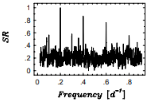

Figura 3: Exemplo de um gráfico após utilização do método BLS em uma série temporal. Figura obtida de **[6]**.

$\quad$Existem alguns métodos para otimizar o trabalho computacional do algoritmo, além de outros procedimentos estatísticos que buscam minimizar os desvios e medir a eficiência do processo. Entretanto, para este Notebook, não há necessidade de tal aprofundamento. Se o leitor demonstrar interesse, por favor, consulte a referência **[6]**.

### 3.2 Vantagens e desvantagens do método

$\quad$O algoritmo BLS se mostra extremamente eficiente para a detecção de períodos de trânsito planetários que provocam uma "forma de caixa" no gráfico fotométrico da estrela. O método se torna mais rápido devido à simplificação da modelagem do trânsito, além de conseguir identificar com precisão o período procurado. Outra vantagem que pode ser listada é que o BLS funciona muito bem mesmo para baixos valores da razão sinal-ruído. Quando isso acontece, o sinal periódico não pode ser obtido com apenas um trânsito; na verdade, são necessárias diversas medições para que tal sinal apareça. O algoritmo consegue lidar com esses grandes números de observações muito bem, sem perder eficiência computacional.

$\quad$Entretanto, precisamos comentar sobre alguns pontos em que o método não consegue entregar bons resultados. Em primeiro lugar, lembremos que, apesar da eficiência pela modelagem simples do trânsito, sabemos que a variação do fluxo luminoso da estrela não segue o mesmo comportamento que uma função degrau. Na verdade, no início e no fim do trânsito, há uma transição mais suavizada entre os níveis de referência do trânsito (níveis $H$ e $L$ da discussão da seção **3.1**). Essa transição carrega informações sobre parâmetros planetários que não são evidenciados. Uma alternativa para esse problema seria, por exemplo, após detectarmos o período, recuperarmos essa transição da entrada e saída do trânsito para as devidas caracterizações.

$\quad$Além disso, outro problema é a limitação sobre a forma do sinal que pode ser interpretado e computado pelo algoritmo. Lembremos que o BLS modela séries temporais a partir de funções degrau. Dessa forma, o formato obtido da curva de luz deve se assemelhar a essa função, ou a "uma caixa", para que o algoritmo tenha funcionalidade. Em comparação com outros métodos, esse se mostra limitado ao formato do sinal, enquanto outros, como a transformada de Fourier, lidam bem com sinais de formatos diversos.

## 4. Aplicação e modelagem

$\quad$Primeiro, procuramos a curva de luz desejada do nosso objeto de interesse para realizarmos a busca de seu período orbital. O objeto em questão é a estrela hospedeira do exoplaneta TOI-1408b **[1]**. Buscamos seu TICID no catálogo SIMBAD e salvamos na variável TOI. Tendo isso, pesquisamos a curva de luz com a função `search_lightcurve`, que retornará uma tabela com todas as curvas de luz disponíveis para a determinada estrela.  

In [16]:
TOI = 'TIC 364186197'
search_result = lk.search_lightcurve(TOI, mission = 'Tess') 
# Como queremos trabalhar apenas com dados da missão TESS, restringimos a busca das curvas de luz.
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 18,2019,SPOC,120,364186197,0.0
1,TESS Sector 16,2019,SPOC,120,364186197,0.0
2,TESS Sector 19,2019,SPOC,120,364186197,0.0
3,TESS Sector 17,2019,SPOC,120,364186197,0.0
4,TESS Sector 24,2020,SPOC,120,364186197,0.0
5,TESS Sector 25,2020,SPOC,120,364186197,0.0
6,TESS Sector 58,2022,SPOC,20,364186197,0.0
7,TESS Sector 59,2022,SPOC,20,364186197,0.0
8,TESS Sector 57,2022,SPOC,20,364186197,0.0


$\quad$Observamos que há uma boa quantidade de dados disponíveis. Entretanto, estes são de autores diferentes e setores não seguidos. Se utilizarmos todas as curvas, o sinal resultante ficará deformado, não sendo interessante para a implementação do algoritmo. Então, para facilitar, restringimos para os setores 16 ao 19, e com autores que estruturam os dados da mesma forma, como no caso do TESS-SPOC e SPOC.

In [17]:
search_result = lk.search_lightcurve(TOI, mission = 'Tess', author = ['TESS-SPOC','SPOC'], sector=[16,17,18,19])
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 16,2019,SPOC,120,364186197,0.0
1,TESS Sector 17,2019,SPOC,120,364186197,0.0
2,TESS Sector 18,2019,SPOC,120,364186197,0.0
3,TESS Sector 19,2019,SPOC,120,364186197,0.0
4,TESS Sector 16,2019,TESS-SPOC,1800,364186197,0.0
5,TESS Sector 17,2019,TESS-SPOC,1800,364186197,0.0
6,TESS Sector 18,2019,TESS-SPOC,1800,364186197,0.0
7,TESS Sector 19,2019,TESS-SPOC,1800,364186197,0.0


$\quad$Com essa filtragem, agora estamos disponíveis a coletar os sinais para trabalhar. Utilizamos a função `download_all` para baixar as curvas em nosso computador e plotamos para vermos o que temos.

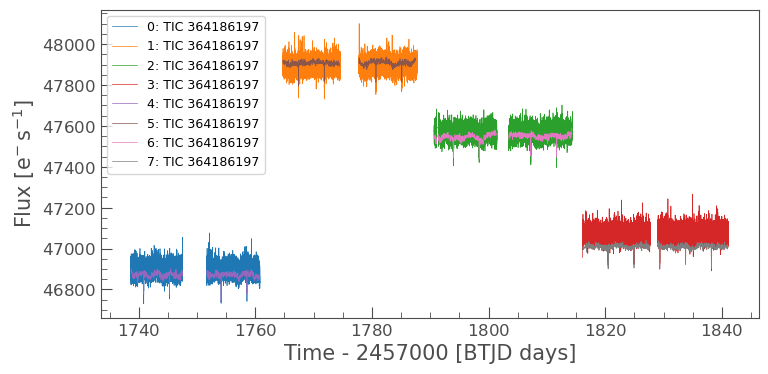

In [18]:
tess = search_result.download_all()
tess.plot()
plt.legend(fontsize="9", loc ="upper left")


$\quad$Agora, normalizamos o fluxo e "costuramos" os dados para tirar as descontinuidades usando o `stitch`. Em seguida, removemos os outliers (pontos que divergem muito dos demais na série temporal).

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

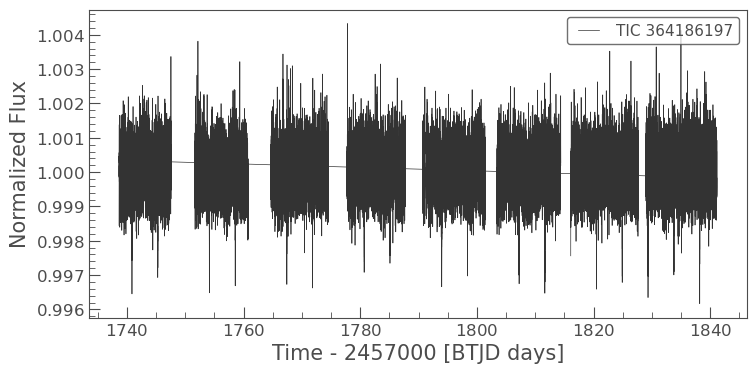

In [19]:
tess = tess.stitch() 
tess.plot()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

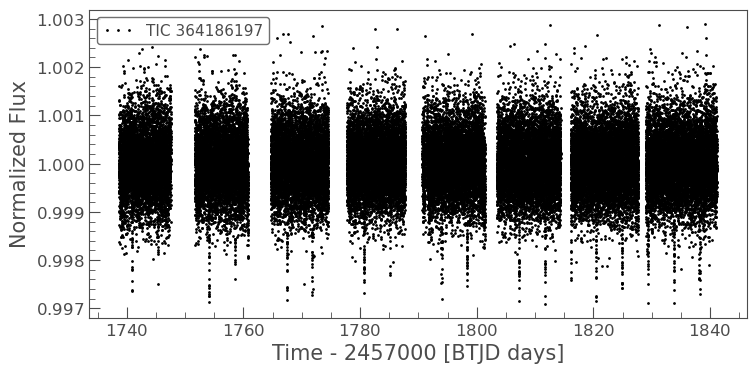

In [20]:
tess = tess.flatten(window_length = 1790).remove_outliers() 
## Esse e o passo anterior podem ser realizados na mesma linha de código.
tess.plot(linewidth = 0, marker = '.',  color = 'black') 


$\quad$Aqui, estaremos fazendo um dos principais pontos desse `notebook`. Vamos utilizar a função `t0_periodogram` para construir um periodograma da curva de luz acima utilizando o algoritmo BLS discutido na seção **3**. Para quem não conhece, o periodograma se trata de um gráfico que mostra a intensidade de cada período presente no sinal. Limitamos também o período máximo exibido no gráfico para 20 dias para melhor observação. Adiantamos que o período orbital obtido é inferior a 20 dias, dessa forma tal limitação não influencia na análise dos dados. 

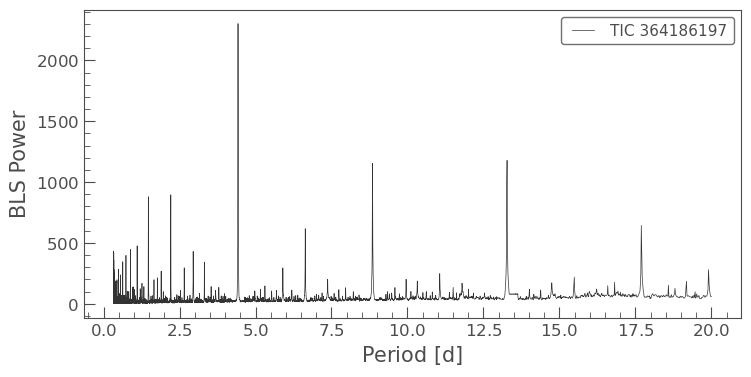

In [21]:
pg = tess.to_periodogram(method='bls', maximum_period=20)
pg.plot(view='period');

$\quad$Com o periodograma montado, agora coletamos as informações que precisamos para a modelagem do nosso trânsito. Utilizamos os seguintes comandos para coletarmos dados de período, época e duração do trânsito no pico do nosso gráfico. Se o leitor bem se lembra, todos esses parâmetros são estimados pelo algoritmo para buscar o período que maximiza a expressão **(11)**. Agora estamos resgatando os dados que produzem o maior "ajuste" do modelo com a curva de luz. 

In [22]:
planet_period = pg.period_at_max_power
planet_b_t0 = pg.transit_time_at_max_power
planet_b_dur = pg.duration_at_max_power

# Checando o valor do período:
planet_period

<Quantity 4.42463484 d>

$\quad$A fim de comprovar a eficiência do algoritmo, vamos comparar o resultado do período obtido com os dados disponíveis na literatura **[1]**. O valor do período encontrado no artigo da caracterização do planeta é de aproximadamente 4.4247110 dias. Ao calcularmos o desvio da nossa medida com a disponível na literatura, obtemos uma diferença de apenas $\Delta T \% = 1,7 \cdot 10^{-3} \%$.

$\quad$Utilizando os parâmetros do trânsito obtidos anteriormente, dobramos a curva de luz, de modo a obter um gráfico mais simples de analisar e visualizar o trânsito. Para isso, usamos a função `fold` com os devidos argumentos.

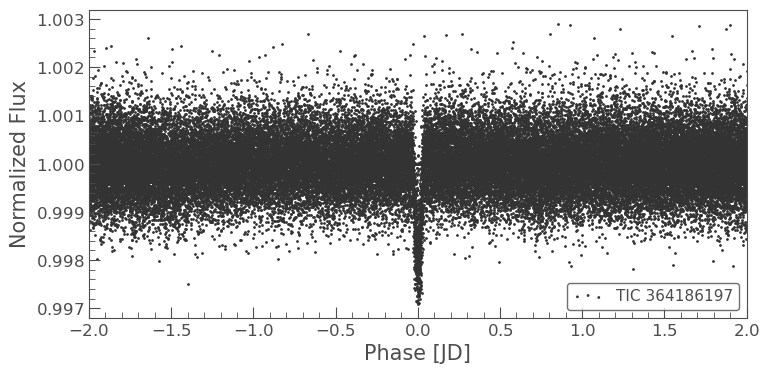

In [23]:
ax = tess.fold(period=planet_period, epoch_time=planet_b_t0).scatter()
ax.set_xlim(-2, 2);

$\quad$Para finalizarmos, vamos modelar o trânsito do planeta, visualizando assim como o algoritmo prevê o formato do sinal e consegue aferir precisamente o período do nosso exoplaneta de interesse. Começamos criando uma variável para o modelo e inserimos novamente as características do período que mais se encaixa à curva de luz. Posteriormente, plotamos em um mesmo gráfico a curva de luz dobrada e o modelo, em vermelho.

(-2.0, 2.0)

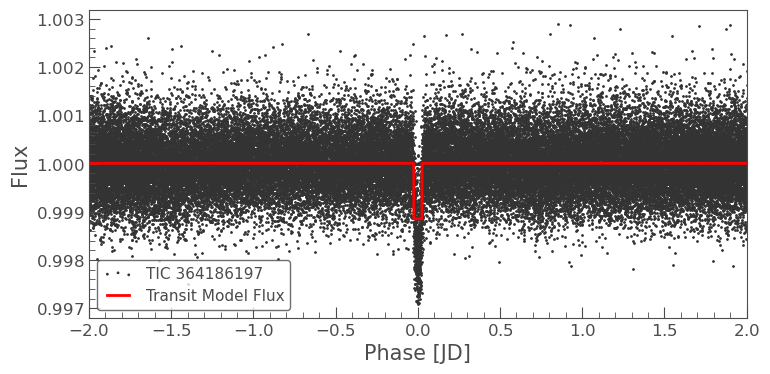

In [24]:
planet_b_model = pg.get_transit_model(period=planet_period,
                                       transit_time=planet_b_t0,
                                       duration=planet_b_dur)
ax = tess.fold(period=planet_period, epoch_time=planet_b_t0).scatter()
planet_b_model.fold(planet_period, planet_b_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-2, 2)

## Conclusão

$\quad$Nesse projeto, abordamos conceitos essenciais para a astronomia e a exoplanetologia. Discutimos o conceito de trânsito planetário e como a interação (nesse caso, luminosa) entre a estrela e o planeta nos ajuda a identificar indiretamente novos exoplanetas. Apresentamos o conceito de fluxo luminoso, curva de luz e periodogramas, que são peças-chave para a exoplanetologia, além de mencionar como acontece o trabalho da missão TESS.

$\quad$Em seguida, buscamos mostrar uma visão estatística de um algoritmo para a detecção de período orbital a partir do trânsito planetário. Após uma grande discussão sobre o método BLS, implementamos um código buscando detectar o período orbital do exoplaneta TOI-1408b.

$\quad$Com o código feito, conseguimos modelar o trânsito do nosso planeta a partir de funções obtidas na biblioteca, para comprovar as considerações feitas na análise estatística do BLS. Posteriormente, comparamos o nosso valor obtido com o artigo que caracterizou o mesmo exoplaneta. Obtivemos um erro relativo de apenas $1,7 \cdot 10^{-3} \%$. O pequeno desvio mostra que o método utilizado neste `Notebook` está coerente com os métodos empregados por outros pesquisadores.

$\quad$Concluímos, em suma, que a implementação do método, em geral, foi um sucesso. Além de a biblioteca se mostrar simples de ser utilizada, conseguimos adquirir valores totalmente coerentes com os esperados. Por fim, percebemos que este `Notebook` se mostra proveitoso para a identificação e caracterização de exoplanetas de forma simples.

## Referências 

**[1]** Ge, J. and Zeng, L., 2023. Doppler confirmation of TESS planet candidate TOI-1408.01: Grazing transit and likely eccentric orbit. Astronomy & Astrophysics, 675, pp.A65. 

**[2]** Cassen, P., Guillot, T. and Quirrenbach, A. (eds.), 2006. Extrasolar Planets. University of Arizona Press, pp. 115-123.

**[3]** Léna, P. and Lebrun, F., 2012. Observational Astrophysics. 3rd ed. Springer, pp. 79-102.

**[4]** Lightkurve, 2023. Exoplanets: Identifying Transiting Planet Signals.

**[5]** Space Telescope Science Institute, 2018. TESS Instrument Handbook Version 0.1.

**[6]** Kovács, G., Zucker, S. and Mazeh, T., 2002. A box-fitting algorithm in the search for periodic transits. Astronomy & Astrophysics, 391 (3), pp. 369-375.

**[7]** Mayor, M. and Queloz, D., 1995. Nature 378, 355

**[8]** NASA Exoplent Archive, 2024.